### Import necessary libraries

In [1]:
import pandas as pd
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et 

from PIL import Image
from IPython.display import display


### Set dir with dataset

In [2]:
path = "../data/raw/military-aircraft-recognition-dataset"

### Check what dataset contain

In [3]:
for dirpath, dirnames, filenames in os.walk(path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'")

There are 3 directories and 0 files in '../data/raw/military-aircraft-recognition-dataset'
There are 2 directories and 0 files in '../data/raw/military-aircraft-recognition-dataset\Annotations'
There are 0 directories and 3842 files in '../data/raw/military-aircraft-recognition-dataset\Annotations\Horizontal Bounding Boxes'
There are 0 directories and 3842 files in '../data/raw/military-aircraft-recognition-dataset\Annotations\Oriented Bounding Boxes'
There are 1 directories and 0 files in '../data/raw/military-aircraft-recognition-dataset\ImageSets'
There are 0 directories and 2 files in '../data/raw/military-aircraft-recognition-dataset\ImageSets\Main'
There are 0 directories and 3842 files in '../data/raw/military-aircraft-recognition-dataset\JPEGImages'


### Let's check what jpeg directory contain

In [4]:
images = "../data/raw/military-aircraft-recognition-dataset\JPEGImages"
images_names = os.listdir(images)
len(images_names), images_names[:20]

(3842,
 ['1.jpg',
  '10.jpg',
  '100.jpg',
  '1000.jpg',
  '1001.jpg',
  '1002.jpg',
  '1003.jpg',
  '1004.jpg',
  '1005.jpg',
  '1006.jpg',
  '1007.jpg',
  '1008.jpg',
  '1009.jpg',
  '101.jpg',
  '1010.jpg',
  '1011.jpg',
  '1012.jpg',
  '1013.jpg',
  '1014.jpg',
  '1015.jpg'])

### It is just 3842 .jpg images named with some integer value 


### Let's check how annotation data look like

In [5]:
annotations_h_path = "../data/raw/military-aircraft-recognition-dataset\Annotations\Horizontal Bounding Boxes"
annotations_o_path = "../data/raw/military-aircraft-recognition-dataset\Annotations\Oriented Bounding Boxes"

annotations_h = os.listdir(annotations_h_path)
print(annotations_h[:10])
annotations_o = os.listdir(annotations_o_path)
print(annotations_o[:10])


with open(os.path.join(annotations_h_path, annotations_h[0]), "r") as file:
        xml_data = file.read()
print(xml_data)

with open(os.path.join(annotations_o_path, annotations_o[0]), "r") as file:
        xml_data = file.read()
print(xml_data)

['1.xml', '10.xml', '100.xml', '1000.xml', '1001.xml', '1002.xml', '1003.xml', '1004.xml', '1005.xml', '1006.xml']
['1.xml', '10.xml', '100.xml', '1000.xml', '1001.xml', '1002.xml', '1003.xml', '1004.xml', '1005.xml', '1006.xml']
<annotation>
	<filename>1.xml</filename>
	<source>
		<database>MAR20</database>
	</source>
	<size>
		<width>859</width>
		<height>831</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>A2</name>
		<bndbox>
			<xmin>485</xmin>
			<ymin>427</ymin>
			<xmax>554</xmax>
			<ymax>500</ymax>
		</bndbox>
	</object>
	<object>
		<name>A2</name>
		<bndbox>
			<xmin>694</xmin>
			<ymin>487</ymin>
			<xmax>770</xmax>
			<ymax>562</ymax>
		</bndbox>
	</object>
	<object>
		<name>A10</name>
		<bndbox>
			<xmin>58</xmin>
			<ymin>205</ymin>
			<xmax>134</xmax>
			<ymax>285</ymax>
		</bndbox>
	</object>
</annotation>
<annotation><filename>1.jpg</filename><source><database>MAR20</database></source><size><width>859</width><height>831</height><depth>3

### Oriented seems to be not so good let's add new lines.
### Object should look like this

In [6]:
str = '''
<object>
        <type>robndbox</type>
        <name>A2</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <robndbox>
            <x_left_top>516.2807017543859</x_left_top>
            <y_left_top>414.78947368421046</y_left_top>
            <x_right_top>570.6666666666666</x_right_top>
            <y_right_top>445.4912280701754</y_right_top>
            <x_right_bottom>524.1754385964912</x_right_bottom>
            <y_right_bottom>517.4210526315788</y_right_bottom>
            <x_left_bottom>469.7894736842104</x_left_bottom>
            <y_left_bottom>484.0877192982456</y_left_bottom>
        </robndbox>
        <angle>0</angle>
    </object>
'''

In [ ]:
print(str)

### Util function to parse xml

In [8]:
def parse_horizontal_xml(path_to_xml):
    xtree = et.parse(path_to_xml)
    xroot = xtree.getroot()
    
    filename = []
    database = []
    width = []
    height = []
    depth = []
    segmented = []

    object_data = []
    
    filename.append(xroot.find("filename").text)
    database.append(xroot.find(".//source/database").text)
    width.append(int(xroot.find(".//size/width").text))
    height.append(int(xroot.find(".//size/height").text))
    depth.append(int(xroot.find(".//size/depth").text))
    segmented.append(int(xroot.find("segmented").text))
    
    for obj in xroot.findall(".//object"):
        object_name = obj.find("name").text
        xmin = int(obj.find(".//bndbox/xmin").text)
        ymin = int(obj.find(".//bndbox/ymin").text)
        xmax = int(obj.find(".//bndbox/xmax").text)
        ymax = int(obj.find(".//bndbox/ymax").text)
        object_data.append((object_name, xmin, ymin, xmax, ymax))
    
    return [filename, database, width, height, depth, segmented], object_data



In [9]:
def parse_oriented_xml(path_to_xml):
    xtree = et.parse(path_to_xml)
    xroot = xtree.getroot()
    
    filename = []
    database = []
    width = []
    height = []
    depth = []
    segmented = []

    object_data = []
    
    filename.append(xroot.find("filename").text)
    database.append(xroot.find(".//source/database").text)
    width.append(int(xroot.find(".//size/width").text))
    height.append(int(xroot.find(".//size/height").text))
    depth.append(int(xroot.find(".//size/depth").text))
    segmented.append(int(xroot.find("segmented").text))


    
    for obj in xroot.findall(".//object"):
        object_name = obj.find("name").text
        x_left_top = float(obj.find(".//robndbox/x_left_top").text)
        x_right_top = float(obj.find(".//robndbox/x_right_top").text)
        y_left_top = float(obj.find(".//robndbox/y_left_top").text)
        y_right_top = float(obj.find(".//robndbox/y_right_top").text)
        x_left_bottom = float(obj.find(".//robndbox/x_left_bottom").text)
        x_right_bottom = float(obj.find(".//robndbox/x_right_bottom").text)
        y_left_bottom = float(obj.find(".//robndbox/y_left_bottom").text)
        y_right_bottom = float(obj.find(".//robndbox/y_right_bottom").text)
        object_data.append((object_name, x_left_top, y_left_top, x_right_top, y_right_top,
                             x_right_bottom,  y_right_bottom, x_left_bottom, y_left_bottom,))
    
    return [filename, database, width, height, depth, segmented], object_data



### Let's try reproduce labels and compare to photo. First of all, let's get random photo and place boxes(horizontal and oriented).

3253.jpg


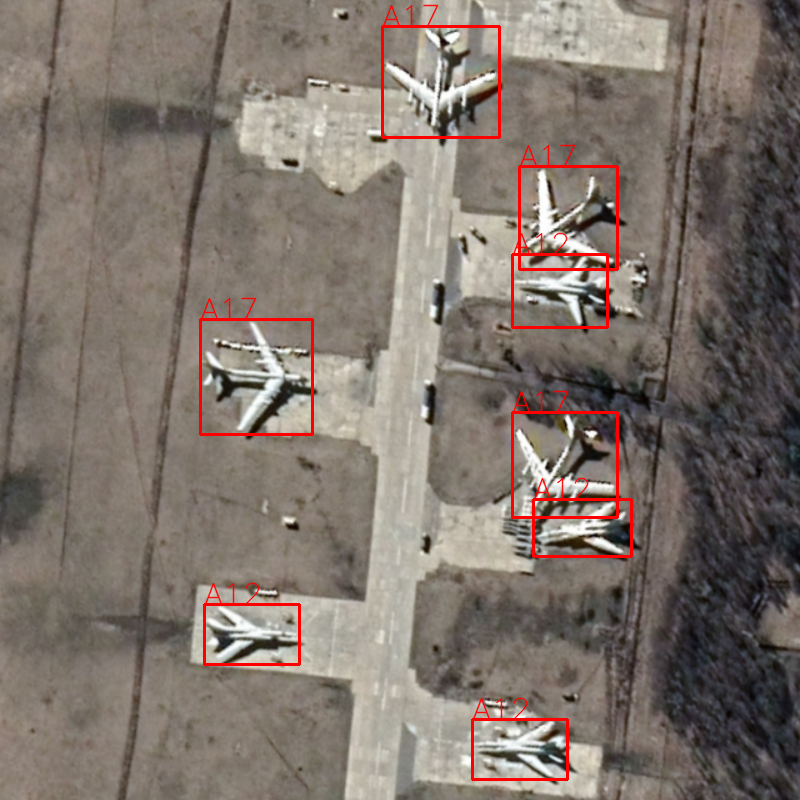

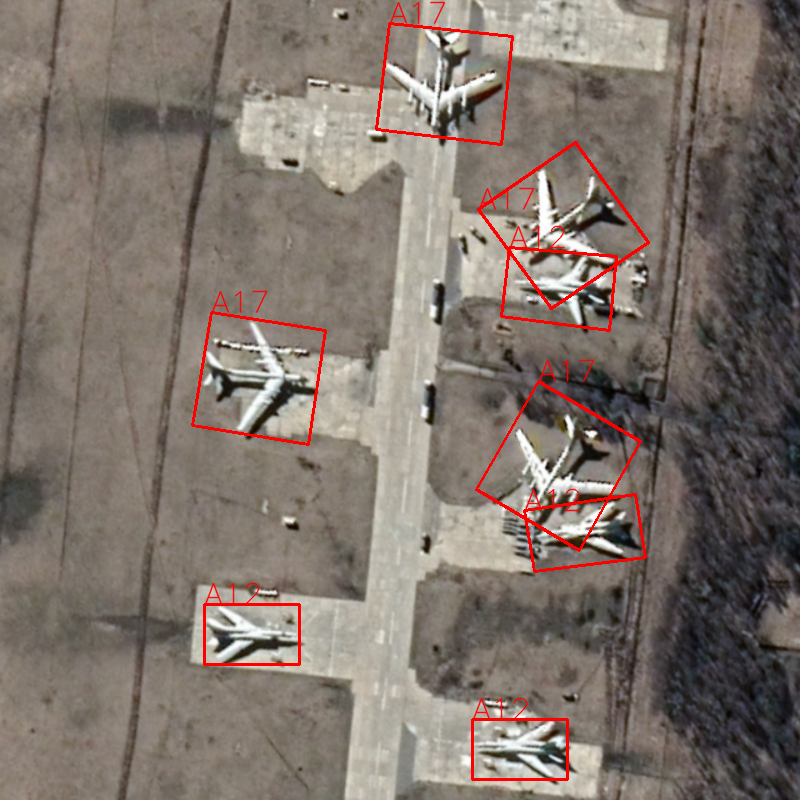

In [11]:
random_image_name = random.choice(images_names)
print(random_image_name)


annotation_h_path =  os.path.join(annotations_h_path, os.path.splitext(random_image_name)[0]+'.xml')

image_data, bboxes = parse_horizontal_xml(annotation_h_path)
random_image_path = os.path.join(images, random_image_name)

image = cv2.imread(random_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for bbox in bboxes:
    cv2.rectangle(image, (bbox[1],bbox[2]), ((bbox[3],bbox[4])), (255,0,0), 2)
    cv2.putText(image, bbox[0], (bbox[1],bbox[2]), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0),1, cv2.LINE_AA)
display(Image.fromarray(image))





annotation_o_path =  os.path.join(annotations_o_path, os.path.splitext(random_image_name)[0]+'.xml')

image_data, bboxes = parse_oriented_xml(annotation_o_path)
random_image_path = os.path.join(images, random_image_name)

image = cv2.imread(random_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for bbox in bboxes:
    points = np.array([[bbox[1],bbox[2]],
                       [bbox[3],bbox[4]],
                       [bbox[5],bbox[6]],
                       [bbox[7],bbox[8]]])
    points = points.reshape((-1, 1, 2)).astype(int)
    cv2.polylines(image, [points], isClosed=True, color=(255, 0, 0), thickness=2)
    print()
    cv2.putText(image, bbox[0], (points[0][0][0], points[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0),1, cv2.LINE_AA)
display(Image.fromarray(image))
